In [1]:
#!pip3 install torch torchvision

In [2]:
#!python3 -m pip install -U matplotlib

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [1]:
#!git clone https://github.com/jaddoescad/ants_and_bees.git

In [2]:
#!ls

In [3]:
#!ls ants_and_bees

In [4]:
#!ls ants_and_bees/train

In [5]:
#!ls ants_and_bees/train/ants

In [4]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

training_dataset = datasets.ImageFolder('weapons/train', transform=transform_train)
validation_dataset = datasets.ImageFolder('weapons/val', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 20, shuffle=False)

In [5]:
print(len(training_dataset))
print(len(validation_dataset))

944
255


In [6]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

In [7]:
#!pip install Pillow==4.0.0

In [7]:
classes = ('arma_blanca', 'arma_corta', 'arma_larga', 'disfraz')

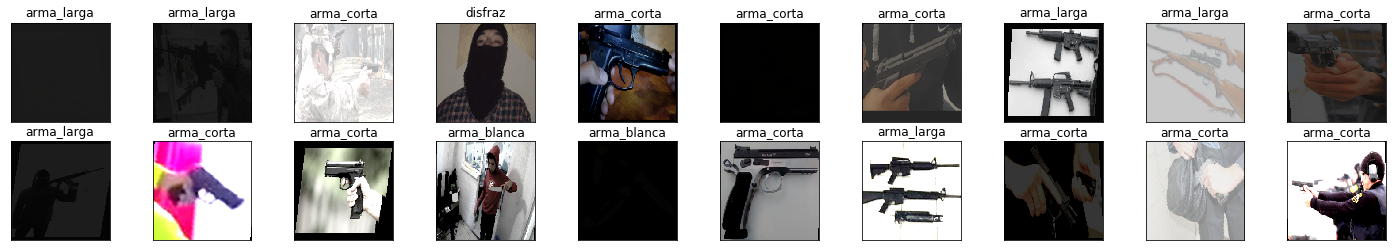

In [8]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [9]:
#model = models.resnet18(pretrained=True)
#model.fc = torch.nn.Linear(512, 4)
#model = models.alexnet(pretrained=True)
model = models.vgg16(pretrained=True)

In [10]:
#print(model)

In [11]:
for param in model.features.parameters():
    param.requires_grad = False

In [12]:
import torch.nn as nn

n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)
print(model.classifier[6].out_features)
print(device)

4
cuda:0


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [15]:
epochs = 5
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
BEST_MODEL_PATH = 'best_model_vgg16.pth'
best_accuracy = 0.0


for e in range(epochs):
  
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
  
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
        
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
      
        epoch_loss = running_loss/len(training_loader.dataset)
        epoch_acc = running_corrects.float()/ len(training_loader.dataset)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
    
        val_epoch_loss = val_running_loss/len(validation_loader.dataset)
        val_epoch_acc = val_running_corrects.float()/ len(validation_loader.dataset)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        print('epoch :', (e+1))
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
        
        test_accuracy = val_epoch_acc        
        if test_accuracy > best_accuracy:
            torch.save(model.state_dict(), BEST_MODEL_PATH)
            best_accuracy = test_accuracy

epoch : 1
training loss: 0.0185, acc 0.8612 
validation loss: 0.0258, validation acc 0.8667 
0: 0.866667
epoch : 2
training loss: 0.0171, acc 0.8528 
validation loss: 0.0311, validation acc 0.8745 
1: 0.874510
epoch : 3
training loss: 0.0151, acc 0.8761 
validation loss: 0.0362, validation acc 0.8627 
2: 0.862745
epoch : 4
training loss: 0.0142, acc 0.8951 
validation loss: 0.0372, validation acc 0.8745 
3: 0.874510
epoch : 5
training loss: 0.0137, acc 0.8782 
validation loss: 0.0398, validation acc 0.8667 
4: 0.866667


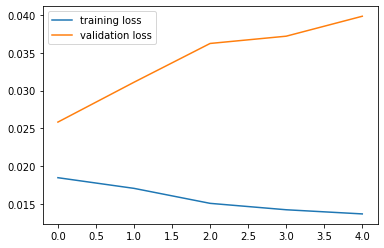

In [16]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

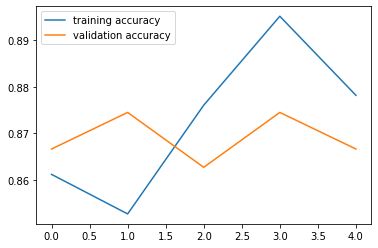

In [17]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [23]:
#!pip3 install pillow==4.0.0

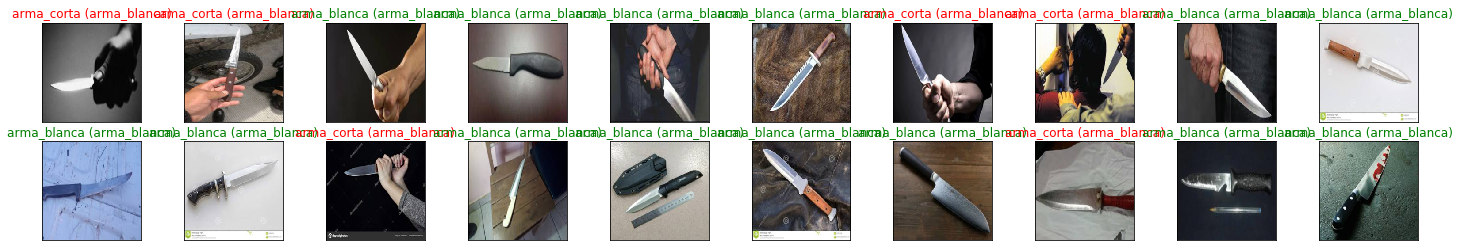

In [21]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

In [25]:
#import PIL.ImageOps

In [24]:
#!pip3 install requests

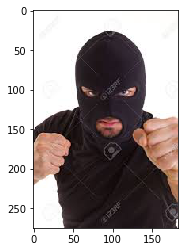

In [18]:
import requests
from PIL import Image

#url = 'https://img.milanuncios.com/fg/2902/69/290269456_2.jpg?VersionId=LPK2MOV7ChahKJZokWAb8P99OZBipxt0' #PISTOLA
#url = 'https://steward.cl/25342-large_default_2x/cuchillo-cocina-medio-golpe-20cm-negro-ivo-professional-inox.jpg' #CUCHILLO
#url = 'https://ocioloco.com/wp-content/uploads/2017/12/1149-ESCOPETA-GOLDEN-M870-CULATA-RIGIDA-NEGRO-Arma-Larga.jpg' #ARMA LARGA
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ-3YKWbkj2rpNzO-Ya2nZOtpxjqm3WLMy3UN6Fuc6HMDx_84Kz'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

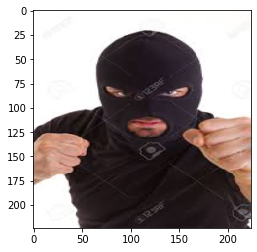

In [19]:
img = transform(img) 
plt.imshow(im_convert(img))

In [20]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

disfraz


# LIVE DEMO

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models
import time
import cv2

In [2]:
#model = models.vgg16(pretrained=False)
model = models.alexnet(pretrained=False)
model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 4)

In [3]:
model.load_state_dict(torch.load('best_modelV2.pth'))
#model = model.eval()

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [4]:
device = torch.device('cuda')
model = model.to(device)

## LIVE IMAGE

In [5]:
transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

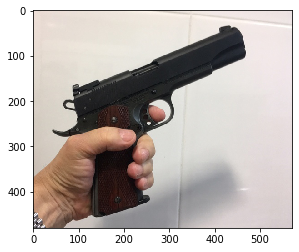

In [9]:
import requests
from PIL import Image

url = 'https://img.milanuncios.com/fg/2902/69/290269456_2.jpg?VersionId=LPK2MOV7ChahKJZokWAb8P99OZBipxt0'
#url = 'https://steward.cl/25342-large_default_2x/cuchillo-cocina-medio-golpe-20cm-negro-ivo-professional-inox.jpg'
#url = 'https://villasombrero.blogs.com/.a/6a00d83451c46e69e201b7c923f282970b-800wi'
#url = 'https://www.elsoldelbajio.com.mx/policiaca/vdfpaf-cuchillo/alternates/LANDSCAPE_400/Cuchillo'

response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)


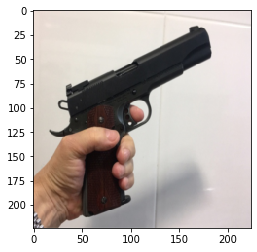

In [10]:
img = transform(img) 
plt.imshow(im_convert(img))

In [11]:
classes = ('arma_blanca', 'arma_corta')
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

arma_corta


## LIVE VIDEO

In [22]:
import traitlets
from IPython.display import display
import ipywidgets.widgets as widgets
from jetcam.usb_camera import USBCamera
from jetcam.utils import bgr8_to_jpeg

camera = USBCamera(width=224, height=224, capture_device=0)
#camera = Camera.instance(width=224, height=224)
image = widgets.Image(format='jpeg', width=224, height=224)
arma_blanca_slider = widgets.FloatSlider(description='arma_blanca', min=0.0, max=1.0, orientation='vertical')
arma_corta_slider = widgets.FloatSlider(description='arma_corta', min=0.0, max=1.0, orientation='vertical')
arma_larga_slider = widgets.FloatSlider(description='arma_larga', min=0.0, max=1.0, orientation='vertical')
disfraz = widgets.FloatSlider(description='disfraz', min=0.0, max=1.0, orientation='vertical')

prediction_widget = widgets.Text(description='prediction')

camera_link = traitlets.dlink((camera, 'value'), (image, 'value'), transform=bgr8_to_jpeg)

display(widgets.HBox([image, arma_blanca_slider, arma_corta_slider, arma_larga_slider, disfraz, prediction_widget]))

camera.running = True

In [6]:
mean = 255.0 * np.array([0.485, 0.456, 0.406])
stdev = 255.0 * np.array([0.229, 0.224, 0.225])

normalize = transforms.Normalize(mean, stdev)

def preprocess(camera_value):
    global device, normalize
    x = camera_value
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = x.transpose((2, 0, 1))
    x = torch.from_numpy(x).float()
    x = normalize(x)
    x = x.to(device)
    x = x[None, ...]
    return x

In [7]:
classes = ('arma_blanca', 'arma_corta', 'arma_larga', 'disfraz')

def update(change):
    global arma_blanca_slider, arma_corta_slider
    x = change['new'] 
    x = preprocess(x)
    y = model(x)
    
    # we apply the `softmax` function to normalize the output vector so it sums to 1 (which makes it a probability distribution)
    y = F.softmax(y, dim=1)   
    _, pred = torch.max(y, 1)
    #prob_blocked = float(y.flatten()[0])
    #prediction_widget.value = classes[y.item()]
    ###########################
    #_, pred = torch.max(y, 1)
    #prediction_widget.value = classes[pred.item()]
            
    arma_blanca_slider.value = float(y.flatten()[0]) 
    arma_corta_slider.value = float(y.flatten()[1])
    arma_larga_slider.value = float(y.flatten()[2])
    disfraz.value = float(y.flatten()[3])

    prediction_widget.value = classes[pred.item()]
    
    #############################################
    #y  = F.softmax(y, dim=1).detach().cpu().numpy().flatten()
    #category_index = y.argmax()
    #prediction_widget.value = classes[category_index.item()]
       
    
    #arma_blanca_slider.value = prob_blocked
    
    #if prob_blocked < 0.5:
     #   robot.forward(0.4)
    #else:
    #    robot.left(0.4)
    
    time.sleep(0.001)
        
update({'new': camera.value})  # we call the function once to intialize

In [8]:
camera.observe(update, names='value')  # this attaches the 'update' function to the 'value' traitlet of our camera


In [9]:
camera.unobserve(update, names='value')